In [17]:
import copy
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.stats import entropy

# Assignment 3

## Generative Adversarial Networks on MNIST

In this assignment you will create and train a GAN to generate images of digits that mimic those in the MNIST dataset.

### Evaluation metric: Inception Score

Rather than just eye-balling whether GAN samples look good or not, researchers have come up with mulitple objective metrics for determining the quality and the diversity of GAN outputs. We will use one of the metrics called the *Inception Score*.

Calculating the Inception Score involves running a pretrained neural network. This is where the name is from: the authors who proposed this metric used a pretrained [Inception Network](https://arxiv.org/pdf/1409.4842.pdf) from Tensorflow in their [paper](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf). Since we will be using the MNIST dataset in this assignment, we provide a simpler neural work pretrained on MNIST as the scoring model.

The idea behind the Inception Score is simple: a good GAN should generate *meaningful* and *diverse* samples. For MNIST, a specific sample is "meaningful" if it looks like any of the 10 digits. When we take a good digit classifier and run it on this sample, it should assign high probability to one of the 10 classes and low probability to the others. In information theory terms, this means the predicted label distribution $p(y|x)$ for any specific sample $x$ should have high entropy. On the other hand, if the generated samples are diverse, they should be able to cover all 10 classes when we generate a large enough set of samples. This means that the "average" label distribution $p(y) = \int p(y|x=G(z)) \mathrm{d}z$ should have low entropy. The Inception Score is define by $\exp (\mathbb{E}_x \mathrm{KL}(p(y|x) || p(y)))$, where $\mathrm{KL}(P||Q)$ is the K-L divergence, which is often used to measure how probability distribution $P$ is different from distribution $Q$. Intuitively, if the generated samples are good, $p(y|x)$ should be different from $p(y)$, since one should have high entropy while the other should have low entropy.

Don't be too worried if you don't fully get how the score is defined and calculated. Just remember that in this assignment, we want our GAN to have a high Inception Score.

In [18]:
# Pretrained model used to evaluation the inception score.
class ScoringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    
def inception_score_mnist(
    imgs,
    model_path='weights/mnist.ckpt',
    batch_size=32,
    num_splits=10,
):
    """Computes the inception score of `imgs`.
    
    Args:
    - imgs: Array of size (number of data points, 1, 28, 28)
    - batch_size: Batch size for feeding data into the pretrained MNIST model.
    - num_splits: Number of splits. We split the samples into multiple subsets
        and calculate the scores on each of them. Their mean is used as the
        final score.
    """
    # Verify that input arguments have the correct formats.
    assert type(imgs) == np.ndarray
    assert imgs.shape[1:] == (1, 28, 28)
    assert batch_size > 0
    assert len(imgs) > batch_size
    
    # Choose device to be used.
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # Preprocess input.
    imgs = copy.copy(imgs)
    imgs = (imgs - 0.1307) / 0.3081
    
    # Set up dataloader.
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load pretrained scoring model.
    model = ScoringModel()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Get predictions.
    preds = []
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            logits = model(batch)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        preds.append(probs)
    preds = np.concatenate(preds)

    # Compute the mean KL divergence.
    split_scores = []

    for i in range(num_splits):
        n = len(imgs) // num_splits
        split = preds[i*n:(i+1)*n, :]
        py = np.mean(split, axis=0)
        scores = []
        for i in range(split.shape[0]):
            pyx = split[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

Now, let's try to calculate the Inception score on the actual MNIST dataset.

Make sure that the provided file `mnist.ckpt` is under `./weights`. Alternatively, you can specify its path via the `model_path` argument of `inception_score_mnist()`. If using Google Colab, click `View > Table of Contents > Files` and then upload it.

In [22]:
transform = torchvision.transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size=500, shuffle=True)

x, y = next(iter(train_loader))
x = x.cpu().data.numpy()
x = x.reshape((-1,1,28,28))
print('Shape of data:',x.shape)
mean, std = inception_score_mnist(x)
print(f'Inception Score: mean={mean:.3f}, std={std:.3f}')

Shape of data: (500, 1, 28, 28)
Inception Score: mean=8.958, std=0.438


In [24]:
x

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.26666668,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0

The score for the real MNIST dataset should be above 8.


### Generating MNIST images (100 points)

As you did with the Gaussian distribution example in the weekly notebook, define and train a GAN to generate images that mimic those in the MNIST dataset.

#### Deliverables

- After training your model, generate at least 1500 samples using the trained generator, and evaluate your model by calculating the Inception score on the generated samples.
- Pick a few generated samples and visualize them.
- Plot the training losses for the discriminator and the generator.

Given the limited computational resources, you will want to achieve an Inception score of 1.5 or greater for full credits. A score of 1.5 won't yield great images. For nice looking images, you'll need an Inception score of around 6.0, but it is not needed for full credits.

#### Model Submission

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that the code runs with no errors and we can grade it easily. In this case, set `epochs = 0` and include the saved model in your submission (or a Google drive share link if its too large).

#### Tips

- It will be easier to get better results with a convolutional GAN. You may find this [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) helpful. The generators of DCGANs make use of transposed convolutions (`nn.ConvTranspose2d` in PyTorch) to map features to larger sizes. This [article](https://d2l.ai/chapter_computer-vision/transposed-conv.html) does a good job illustrating how they work.
- Feel free to try different architectures, layers, optimizers, training schemes and other hyperparameters. Particularly, if training with one type of optimizer is slow or unstable, give other types of optimizers a try.

There are plenty of online resources about GAN that you can reference for inspiration. But do not plagiarize. Please write your own custom networks.

In [3]:

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

cpu


In [8]:
#Loading the training data
train = pd.read_csv('data/mnist_csv_format/mnist_train.csv')

In [9]:
train_data = train.drop(labels = ['label'], axis = 1)
train_data = train_data.values.reshape(-1, 28, 28)
train_data = train_data/255.0

#To create some space
del train

In [10]:
#Just checking if the data type is as expected
print(isinstance(train_data, np.ndarray))

#Checking the sanity of the shape of the training data
print(train_data.shape)

True
(60000, 28, 28)


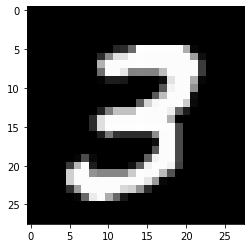

In [11]:
plt.imshow(train_data[7], cmap = 'gray')

In [12]:
#Converting to torch tensor
train_data = torch.Tensor(train_data)

#Checking to confirm dtype as tensor
print(isinstance(train_data, torch.Tensor))

random_seed = 1
batch_size = 32
train_dl = DataLoader(train_data, batch_size, shuffle = True)

True


In [13]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

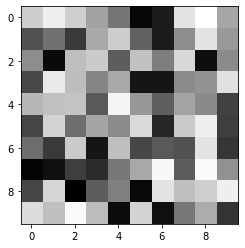

In [16]:
#Just checking the noise generator and plotting one of its outputs
a = random_noise_generator(64, 100)
b = a[2]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

In [17]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        #self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        #self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        #x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        #x = self.conv1_bn(x)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        #x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        #x = self.conv3_bn(x)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

In [18]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        #self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        #x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        #x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        #x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        x = torch.tanh(x)

        return x

In [20]:
D = Discriminator()
G = Generator()

print(D)
print(G)

#Passing to the GPU
D = D.to(device)
G = G.to(device)

D = D.float()
G = G.float()

Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv4): ConvTranspose2d(32, 1, 

In [21]:
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

In [22]:
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [23]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [25]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 25, gen_input_size = 100):

    disc_losses = []
    gen_losses = []

    #Having a fixed sample to monitor the progress of the generator
    sample_size = 16
    fixed_samples = random_noise_generator(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)

    #Going into training mode
    D.train()
    G.train()

    for epoch in range(epochs + 1):

        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0

        for train_x in train_dl:

            #Discriminator training
            disc_opt.zero_grad()

            train_x = train_x*2 - 1          #Converting the real images to have values between -1 and 1
            train_x = train_x.to(device)     #Passing to GPU
            real_out = D(train_x.float())

            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)   #Passing to GPU

            disc_gen_out = G(disc_gen_in.float()).detach()  #Detaching to avoid training the generator
            fake_out = D(disc_gen_out.float())

            disc_loss = discriminator_loss(real_out, fake_out)  #Loss calculation
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()

            #Generator training
            gen_opt.zero_grad()


            gen_out = G(disc_gen_in.float())     #Feeding noise into the generator
            gen_disc_out = D(gen_out.float())       #Passing into the discrminator

            gen_loss = generator_loss(gen_disc_out)  #Generator loss calculation
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()

        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)

        #Plotting samples every 5 epochs
        if epoch%5 == 0:
            G.eval()                    #Going into eval mode to get sample images
            samples = G(fixed_samples.float())
            G.train()                   #Going back into train mode

            fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


        #Printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))

    return disc_losses, gen_losses

In [ ]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, train_dl, batch_size)